### Improve performance on the leaderboard -> Goal is >95%

In [2]:
import os
import tensorflow as tf
import PIL
import pathlib
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
# from collections import counter
import pandas as pd
import numpy as np

In [3]:
training_path = r'D:\kaggle\paddy_doctor_competition\train_images'
testing_path = r'D:\kaggle\paddy_doctor_competition\test_images'

# for notebook
training_path = r'C:\data\paddy_doctor_competition\train_images'
testing_path = r'C:\data\paddy_doctor_competition\test_images'

batch_size = 16
img_dim_h = 256
img_dim_w = 256

In [4]:
image_count = len(list(pathlib.Path(training_path).glob('*/*.jpg')))
ims = list(pathlib.Path(training_path).glob('*/*.jpg'))

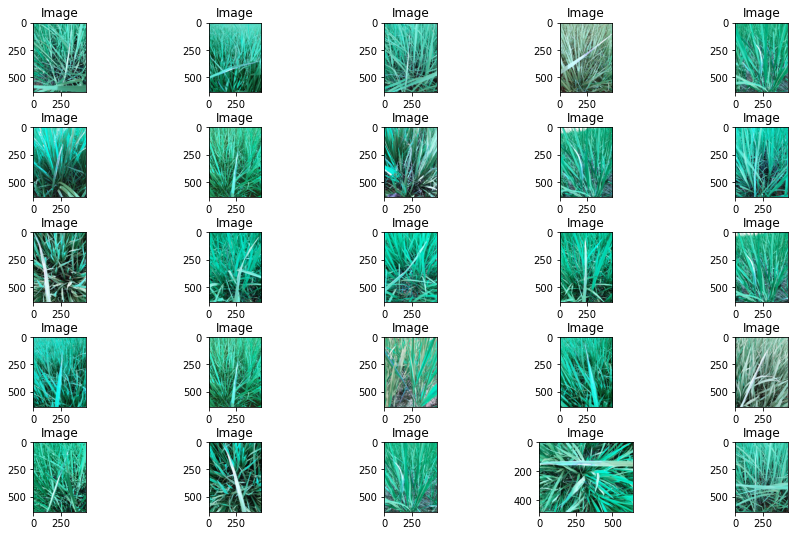

In [5]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(25):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    im = cv2.imread(str(ims[i]))
    plt.imshow(im)
    plt.title('Image')

In [6]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1.0/255.0,
    validation_split=0.2,
    # rotation_range=5,
    # shear_range=0.3,
    # zoom_range=0.3,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    # horizontal_flip=True,
    # vertical_flip=True,
)

In [7]:
train_gen = img_datagen.flow_from_directory(
    training_path,
    subset="training",
    seed=42,
    target_size=(img_dim_h, img_dim_w),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 8330 images belonging to 10 classes.


In [8]:
val_gen = img_datagen.flow_from_directory(
    training_path,
    subset="validation",
    seed=42,
    target_size=(img_dim_h, img_dim_w),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 2077 images belonging to 10 classes.


In [9]:
base_model = tf.keras.applications.convnext.ConvNeXtSmall(
    include_top=False,
    weights='imagenet',
    input_shape=(img_dim_h, img_dim_w, 3),
)

base_model.trainable = False

198551472/198551472 [==============================] - 13s 0us/step


In [68]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, 
    weights = 'imagenet',
    input_shape = (img_dim_h, img_dim_w, 3) 
)

base_model.trainable = False

In [10]:
prediction_layer = tf.keras.layers.Dense(10, activation = "softmax")

inputs = tf.keras.Input((img_dim_h, img_dim_w, 3))
# x = data_augmentation(inputs)

x = tf.keras.applications.convnext.preprocess_input(inputs)
# x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
# x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = prediction_layer(x)

In [11]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.RMSprop(),
  metrics=['accuracy']
)

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='auto', restore_best_weights=True)

In [73]:
model_history = model.fit(train_gen, validation_data=val_gen, batch_size=16, epochs=100, callbacks=[early_stop])

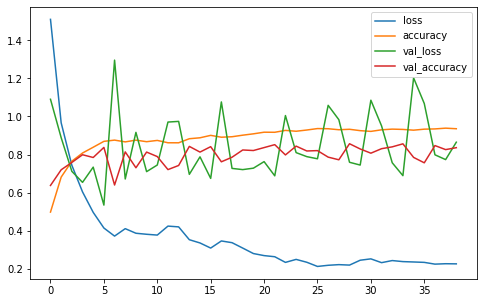

In [74]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.show()

In [75]:
model_path = r'C:\data\paddy_doctor_competition\models\model.h5'
# model.save(r'C:\data\paddy_doctor_competition\models\model.h5')

In [76]:
model = tf.keras.models.load_model(model_path)

### upload submission

In [77]:
testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    # seed = 48,
    labels = None,
    shuffle = False
)

Found 3469 files belonging to 1 classes.


In [78]:
import cv2


In [79]:
predictions = model.predict(testing_data)
predictions.shape

109/109 [==============================] - 41s 342ms/step


(3469, 10)

In [80]:
predictions

array([[6.43949970e-05, 6.99529698e-15, 8.93997029e-12, ...,
        5.77700383e-04, 1.31456852e-01, 2.13336468e-01],
       [4.75604739e-03, 2.85931490e-03, 7.11385874e-05, ...,
        9.09701549e-03, 9.43202913e-01, 8.10513593e-05],
       [2.65621082e-07, 5.04739406e-09, 1.09152825e-06, ...,
        1.99419702e-03, 2.11922641e-04, 2.05474353e-04],
       ...,
       [1.84435351e-06, 3.78197527e-08, 1.08669726e-13, ...,
        1.81543300e-07, 9.99993086e-01, 4.10395664e-08],
       [2.25294661e-02, 3.28253545e-02, 1.45466649e-03, ...,
        2.79708020e-02, 2.85911607e-03, 1.43223479e-02],
       [3.31973407e-11, 7.95363983e-11, 3.48631079e-06, ...,
        4.45629356e-09, 1.77512717e-07, 3.20336680e-14]], dtype=float32)

In [81]:
train_gen.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [82]:
val_gen.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [83]:
labels_int = []
labels_str = []

for key in train_gen.class_indices:
    print('key', key)
    print('value', train_gen.class_indices[key])
    labels_int.append(train_gen.class_indices[key])
    labels_str.append(key)

key bacterial_leaf_blight
value 0
key bacterial_leaf_streak
value 1
key bacterial_panicle_blight
value 2
key blast
value 3
key brown_spot
value 4
key dead_heart
value 5
key downy_mildew
value 6
key hispa
value 7
key normal
value 8
key tungro
value 9


In [84]:
labels_str
# labels_int

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [85]:
# subm_path = r'D:\kaggle\paddy_doctor_competition\sample_submission.csv'
subm_path = r'C:\data\paddy_doctor_competition\sample_submission.csv'

# ss = pd.read_csv(r'D:\kaggle\paddy_doctor_competition\sample_submission.csv')
ss = pd.read_csv(subm_path)

ss['label'] = np.argmax(predictions, axis=-1)
# ss['label'] = ss['label'].replace([0,1,2,3,4,5,6,7,8,9], train_gen.class_names)
ss['label'] = ss['label'].replace(labels_int, labels_str)
ss.to_csv("subm.csv",index=False)
ss.head()

,image_id,label
0,200001.jpg,blast
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [86]:
comp = 'paddy-disease-classification'

In [87]:
from kaggle import api

api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 73.3k/73.3k [00:01<00:00, 50.6kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification